In [1]:
%run lgs03a_data_unification.ipynb

In [90]:
import warnings
warnings.filterwarnings(action='ignore')

In [45]:
def load_predictions_data():
    predictions = pd.read_csv(os.path.join(data_folder, 'predictions','experimentally_tested_predictions.csv'))
    fiji_ctrls = {'cgre_wt': 246, 'cgre_neg': 5, 'amac_wt': 65, 'amac_neg': 4, 'pplu_wt': 191, 'pplu_neg': 4}
    predictions['fiji_log_value'] = np.log10(predictions['fiji_value'])
    predictions['fiji_log_scaled'] = predictions[['fiji_log_value', 'gene']].apply(lambda x:
                                        (x[0] - np.log10(fiji_ctrls[x[1]+'_neg'])) / 
                            (np.log10(fiji_ctrls[x[1]+'_wt']) -  np.log10(fiji_ctrls[x[1]+'_neg'])), axis=1)
    predictions['fiji_log_scaled'] = predictions['fiji_log_scaled'].apply(lambda x: x if x>0 else 0)
    return predictions

In [46]:
predictions = load_predictions_data()

In [47]:
predictions['fraction_nonextant'] = predictions['non_extant_muts'] / predictions['distance']

# Comparison between genes

(-0.5, 8)

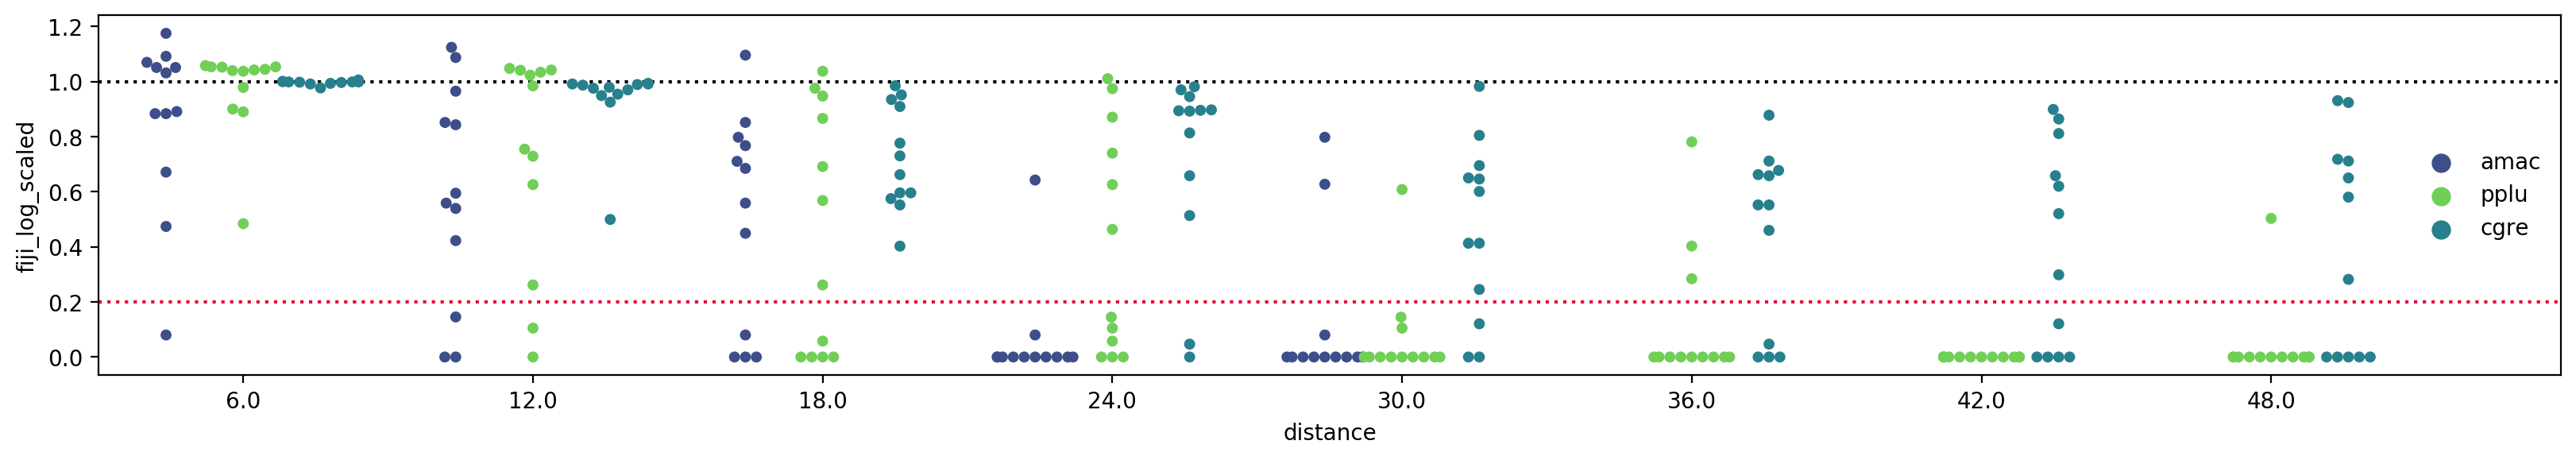

In [133]:
plt.figure(figsize=[20,3], dpi=200)
plt.axhline(1, linestyle=':', color='k')
plt.axhline(0.2, linestyle=':', color='crimson')
ax = sns.swarmplot(data=predictions, x='distance', y='fiji_log_scaled', hue='gene', size=5,
                   palette = [colors['amac'], colors['pplu'], colors['cgre']], dodge=True)
plt.legend(loc='center right', frameon=False)
plt.xlim(-0.5,8)

In [163]:
p_vals = pd.DataFrame(columns=['gene1', 'gene2', 'distance', 'p_fishers', 'p_mwu'])

i = 0
for distance in range(6,49,6):
    for pair in [('amac','pplu'), ('amac','cgre'), ('pplu','cgre')]:
        if 'amac' in pair and distance>30:
            pass
        elif pair[0] != pair[1]:
            all1 = predictions[(predictions.gene==pair[0]) & (predictions.distance==distance)]['fiji_log_scaled']
            all2 = predictions[(predictions.gene==pair[1]) & (predictions.distance==distance)]['fiji_log_scaled']
            
            alive1 = len([x for x in all1 if x>0.2])
            dead1 = 12 - alive1
            alive2 = len([x for x in all2 if x>0.2])
            dead2 = 12 - alive2
            
            p_vals.loc[i] = [pair[0], pair[1], distance, 
                         scipy.stats.fisher_exact([[alive1, alive2],[dead1, dead2]])[1],
                        scipy.stats.mannwhitneyu(all1,all2)[1]]
            i += 1

In [164]:
p_vals

,gene1,gene2,distance,p_fishers,p_mwu
0,amac,pplu,6,1.000000,0.272054
1,amac,cgre,6,1.000000,0.488468
2,pplu,cgre,6,1.000000,0.078336
3,amac,pplu,12,1.000000,0.201047
4,amac,cgre,12,0.217391,0.013082
5,pplu,cgre,12,0.478261,0.465486
6,amac,pplu,18,1.000000,0.465067
7,amac,cgre,18,0.093168,0.106998
8,pplu,cgre,18,0.037267,0.096432
9,amac,pplu,24,0.068650,0.002552


# Extant and non-extant mutations

In [100]:
def distance_fitness_extant_swarm(gene):
    plt.figure(figsize=[20,3], dpi=200)
    plt.axhline(1, linestyle=':', color='k') # wildtype level
    plt.axhline(0.2, linestyle=':', color='crimson') # non-fluorescence threshold
    ax = sns.swarmplot(data=predictions[predictions.gene == gene], 
                       x='distance', y='fiji_log_scaled', hue='fraction_nonextant', size=5, palette = 'mako', )
    ax.get_legend().remove()
    plt.xlim(-0.5,7.5)
    label_plot_axis(t=gene+'GFP', x='Number of mutations', y='Brightness')

    #colormap hack
    col = predictions[predictions.gene == gene]['fraction_nonextant']
    plt.scatter([x-10 for x in col], col, c=col, cmap='mako')
    plt.colorbar(pad=0.01).set_label('Fraction of mutations\nwhich are non-extant')

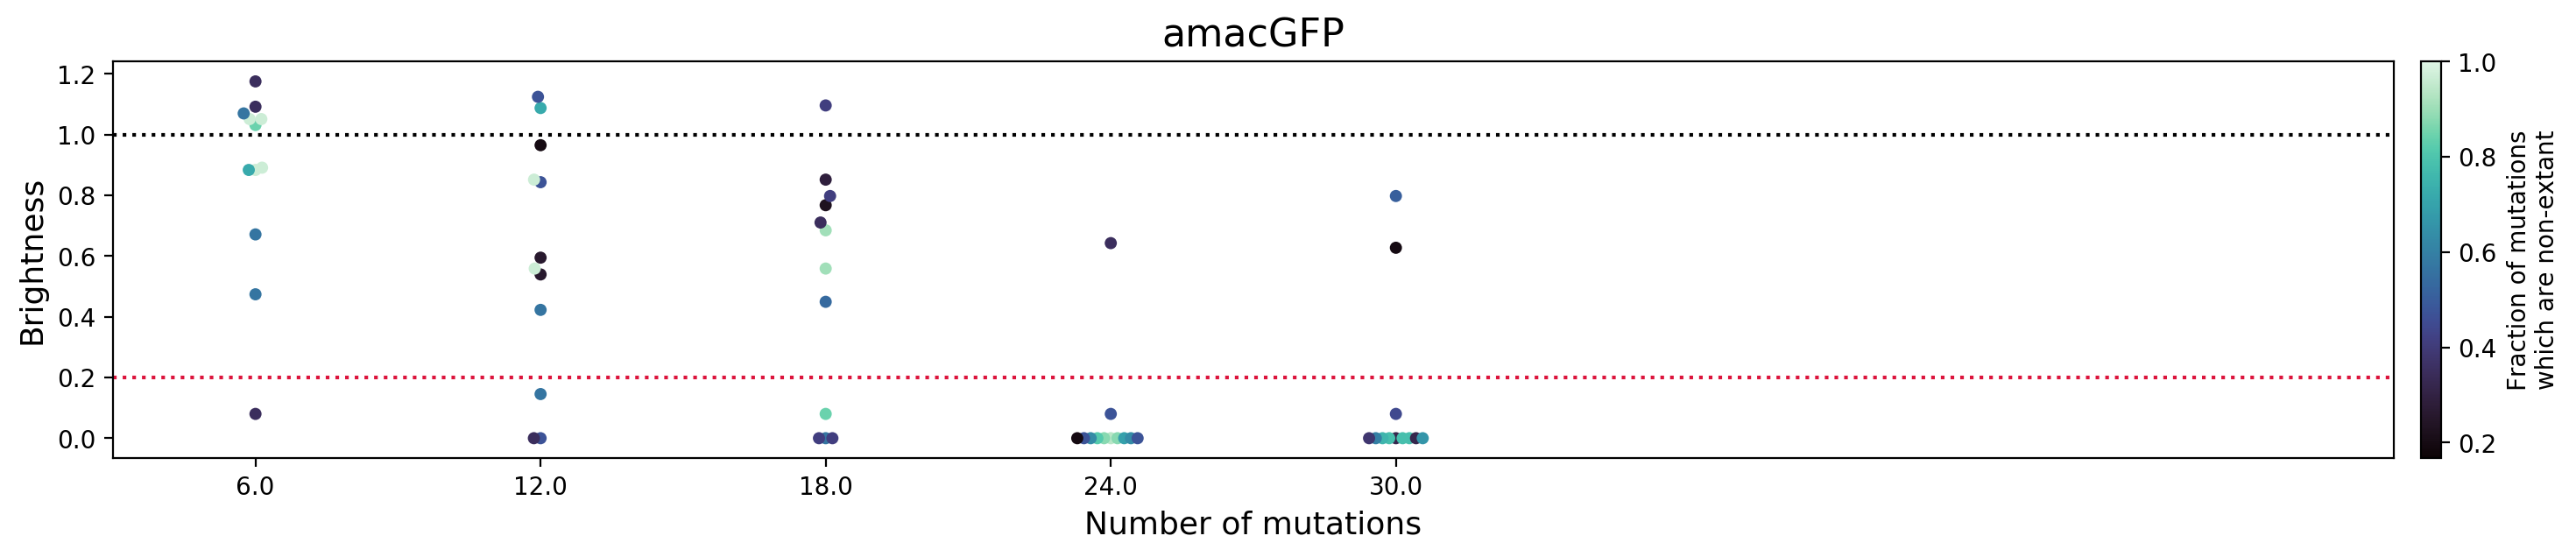

In [101]:
distance_fitness_extant_swarm('amac')

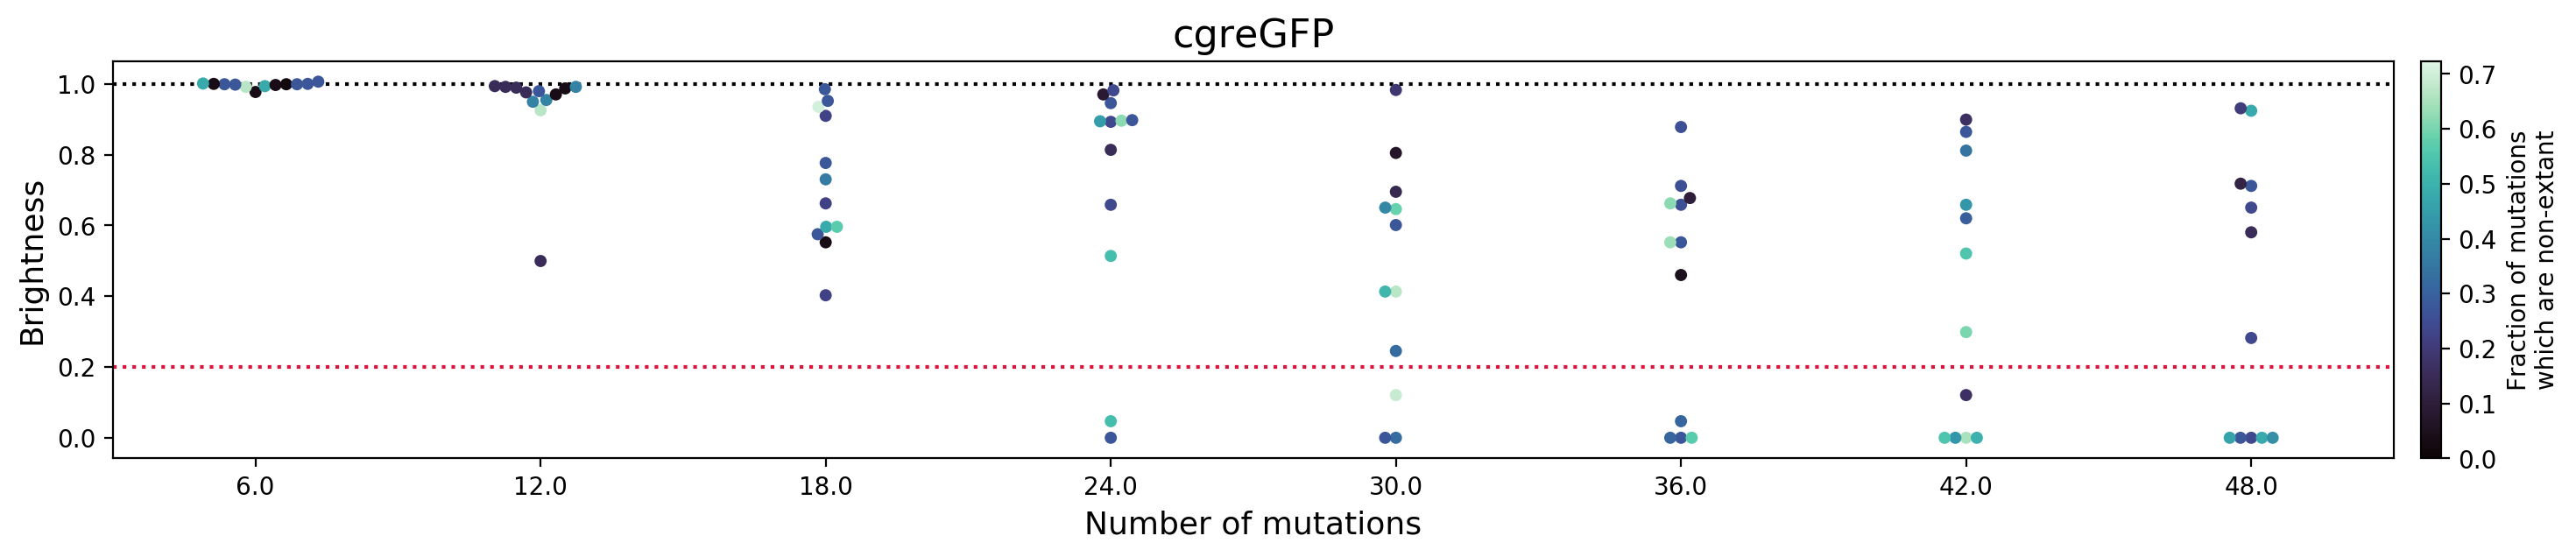

In [102]:
distance_fitness_extant_swarm('cgre')

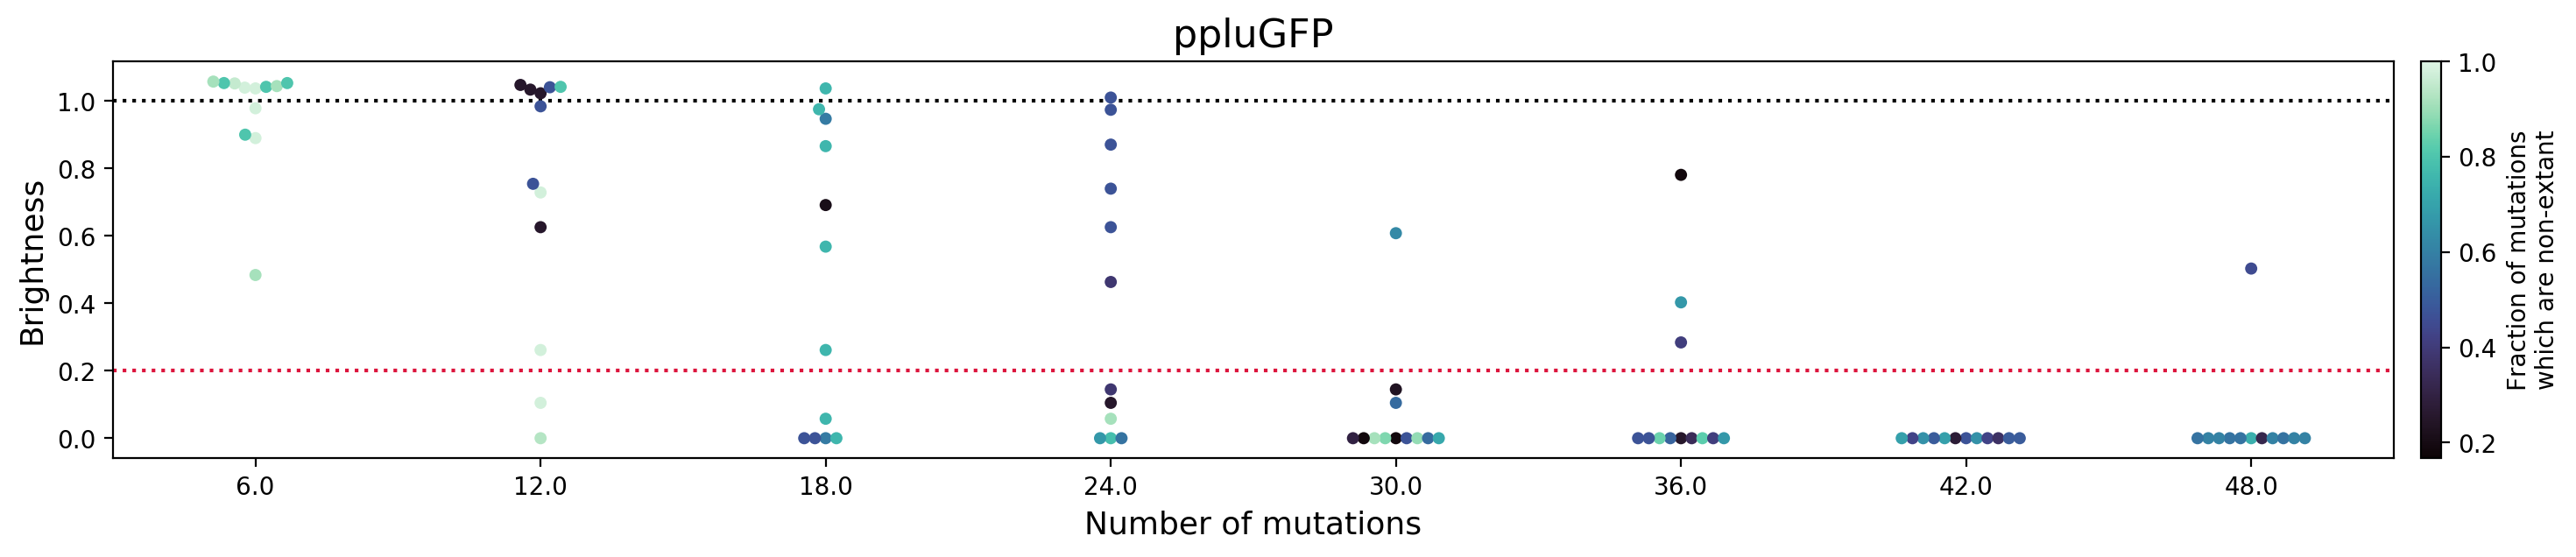

In [103]:
distance_fitness_extant_swarm('pplu')

# Conditionally deleterious mutations

In [160]:
import pickle
bg_data = pickle.load(open('mutation_effects_by_background_log10.pkl', 'rb'))

In [171]:
all_mutations = {gene : set(':'.join(predictions[predictions.gene==gene]['aa_genotype_pseudo']).split(':'))
                for gene in ['amac','cgre','pplu']}

In [189]:
fitness = 0.90
selected = {gene : set(':'.join(predictions[(predictions.gene == gene) & 
                                    (predictions.fiji_log_scaled > fitness)]['aa_genotype_pseudo']).split(':'))
                for gene in ['amac','cgre','pplu']}

e = -0.5
for gene in ['amac', 'cgre', 'pplu']:
    flippers_all = []
    flippers_successful = []
    for mut in all_mutations[gene]:
        if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
            flippers_all.append(mut)
    for mut in selected[gene]:
        if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
            flippers_successful.append(mut)
    print(gene)
    print('all', len(flippers_all) / len(all_mutations[gene]))
    print('selected', len(flippers_successful) / len(selected[gene]))

amac
all 0.04178272980501393
selected 0.056338028169014086
cgre
all 0.13580246913580246
selected 0.10869565217391304
pplu
all 0.11261261261261261
selected 0.06557377049180328
